In [1]:
from skimage import io
from skimage.transform import rescale
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
from data_mgmt import DAO
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
from tensorflow.keras import layers, models, losses


1 Physical GPUs, 1 Logical GPUs


2022-05-12 12:25:56.963073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 12:25:57.082979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 12:25:57.083348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 12:25:57.088819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 12:25:57.089161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [2]:
map_img = io.imread("data/my_map.png")

with open("data/datasetnowall_unidir.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

Model definition

In [3]:
#coda separata (pos, rot)
def model_define(map_img, laser, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch = layers.Conv2D(8, (11,11), padding="valid", name="map_conv_1")(map_input)
    map_branch = layers.Conv2D(16, (7,7), padding="valid", name="map_conv_2")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_1")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_1")(map_branch)
    map_branch = layers.Conv2D(32, (7,7), padding="valid", name="map_conv_3")(map_branch)
    map_branch = layers.MaxPool2D((5,5), strides=2, padding="valid", name="map_pooling_2")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_2")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_4")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_3")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_3")(map_branch)
    map_branch = layers.Conv2D(64, (5,5), padding="valid", name="map_conv_5")(map_branch)
    map_branch = layers.MaxPool2D((3,3), strides=2, padding="valid", name="map_pooling_4")(map_branch)
    map_branch = layers.BatchNormalization(name="map_norm_4")(map_branch)

    map_branch = layers.Flatten()(map_branch)
 
    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(16, 11, padding="same", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(32, 5, padding="same", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.Conv1D(256, kernel_size=5, padding="same", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(2, strides=2, padding="same", name="laser_pool_3" )(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    merged_branch = layers.Concatenate()([map_branch,laser_branch])

    if training:
        merged_branch = layers.Dropout(0.3)(merged_branch)

    merged_branch_pos = layers.Dense(1024, activation="relu", name="fc_merged_pos_1")(merged_branch)
    merged_branch_pos = layers.Dense(256, activation="relu", name="fc_merged_pos_2")(merged_branch_pos)
    merged_branch_pos = layers.Dense(2, name="fc_pos_out")(merged_branch_pos)
    
    merged_branch_rot = layers.Dense(64, activation="relu", name="fc_merged_rot")(merged_branch)
    merged_branch_rot = layers.Dense(1, name="fc_rot_out")(merged_branch_rot)
    
    return models.Model([map_input,laser_input],merged_branch_pos)#[merged_branch_pos, merged_branch_rot])

beta = 0.2

def loss_fn(y_true, y_pred):
    pos_loss = tf.multiply(losses.MeanSquaredError()(y_true[0], y_pred[0]),1-beta)
    rot_loss = tf.multiply(losses.MeanAbsoluteError()(y_true[1], y_pred[1]), beta)

    return layers.Add()([pos_loss, rot_loss])

In [3]:
#coda separata (map_mask, rot_mask)
def model_define(map_img, laser, rot_dim=0, training=True):

    map_input = layers.Input(map_img.shape)
    
    map_branch_1 = layers.Conv2D(8, 11, padding="same", activation="relu", name="map_conv_1")(map_input)
    map_branch_2 = layers.Conv2D(16, 7, padding="same", activation="relu", name="map_conv_2")(map_branch_1)
    map_branch_3 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_1")(map_branch_2)
    map_branch_5 = layers.Conv2D(32, 7, padding="same", activation="relu", name="map_conv_3")(map_branch_3)
    map_branch_6 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_2")(map_branch_5)
    map_branch_8 = layers.Conv2D(64, 5, padding="same", activation="relu", name="map_conv_4")(map_branch_6)
    map_branch_9 = layers.MaxPool2D(3, strides=2, padding="same", name="map_pooling_3")(map_branch_8)
    map_branch_11 = layers.Conv2D(128, 5, padding="same", activation="relu", name="map_conv_5")(map_branch_9)
    map_branch_12 = layers.MaxPool2D(5, strides=3, padding="same", name="map_pooling_4")(map_branch_11)

    if training:
        map_branch_12 = layers.Dropout(0.3)(map_branch_12)
 
    laser_input = layers.Input(laser.shape)

    laser_branch = layers.Conv1D(32, 11, padding="valid", activation="relu", name="laser_conv_1")(laser_input)
    laser_branch = layers.Conv1D(64, 7, padding="valid", activation="relu", name="laser_conv_2")(laser_branch)
    laser_branch = layers.MaxPool1D(5, strides=3, padding="same", name="laser_pool_1" )(laser_branch)
    laser_branch = layers.Conv1D(128, kernel_size=5, padding="valid", activation="relu", name="laser_conv_3" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_2" )(laser_branch)
    laser_branch = layers.Conv1D(256, kernel_size=5, padding="valid", activation="relu", name="laser_conv_4" )(laser_branch)
    laser_branch = layers.MaxPool1D(3, strides=2, padding="same", name="laser_pool_3" )(laser_branch)


    laser_branch = layers.Flatten()(laser_branch)
    
    #merged_branch = layers.Concatenate()([map_branch_flat,laser_branch])

    if training:
        laser_branch = layers.Dropout(0.3)(laser_branch)

    #in_model = models.Model([map_input,laser_input],merged_branch)

    #in_model.trainable = training

    laser_branch = layers.Dense((map_branch_12.shape[1]*map_branch_12.shape[2]*64), activation="relu", name="fc_merged")(laser_branch)
    laser_branch_reshape = layers.Reshape((map_branch_12.shape[1],map_branch_12.shape[2],64))(laser_branch)

    merged_branch_pos = layers.Concatenate()([map_branch_12,laser_branch_reshape])

    merged_branch_pos_1 = layers.Conv2DTranspose(32,5,3, padding="same")(merged_branch_pos)

    #position branch
    
    diff_width = int(merged_branch_pos_1.shape[1] - map_branch_11.shape[1] + 1)
    diff_heigth = int(merged_branch_pos_1.shape[2] - map_branch_11.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(32,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos_1)

    else:
        merged_branch_pos = layers.Conv2D(32,7,activation="relu", padding="same")(merged_branch_pos_1)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_11])
   
    merged_branch_pos = layers.Conv2DTranspose(32,5,2, padding="same")(merged_branch_pos) 

    if training:
        merged_branch_pos = layers.Dropout(0.3)(merged_branch_pos)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_8.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_8.shape[2] + 1)

    padded = False

    if (diff_width > 1) or (diff_heigth > 1):
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(16,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(16,5,activation="relu", padding="same")(merged_branch_pos)

    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_8])

    merged_branch_pos = layers.Conv2DTranspose(16,7,3, padding="same")(merged_branch_pos) 
    
    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)

    diff_width = int(merged_branch_pos.shape[1] - map_branch_5.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_5.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(8,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(8,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_5])

    merged_branch_pos = layers.Conv2DTranspose(8,7,3, padding="same")(merged_branch_pos) 

    diff_width = int(merged_branch_pos.shape[1] - map_branch_2.shape[1] + 1)
    diff_heigth = int(merged_branch_pos.shape[2] - map_branch_2.shape[2] + 1)

    padded = False

    if diff_width > 1 or diff_heigth > 1:
        padded = True

    if padded:
        merged_branch_pos = layers.Conv2D(4,(diff_width,diff_heigth),activation="relu", padding="valid")(merged_branch_pos)

    else:
        merged_branch_pos = layers.Conv2D(4,7,activation="relu", padding="same")(merged_branch_pos)
    
    merged_branch_pos = layers.Concatenate()([merged_branch_pos,map_branch_2])

    merged_branch_pos = layers.Conv2DTranspose(2,11, padding="same", name="pos_output")(merged_branch_pos) 

    #rotation branch

    merged_branch_rot = layers.Conv2D(64,(merged_branch_pos_1.shape[1],1), activation="relu", padding="valid")(merged_branch_pos_1)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)
    
    merged_branch_rot = layers.Reshape((merged_branch_pos_1.shape[2],64))(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(32,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/9) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(16,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(16,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(16,5,3, activation="relu")(merged_branch_rot)

    if training:
        merged_branch_rot = layers.Dropout(0.3)(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - int(rot_dim/3) + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(8,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(8,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.Conv1DTranspose(8,5,3, activation="relu")(merged_branch_rot)

    diff_width = int(merged_branch_rot.shape[1] - rot_dim + 1)
    padded = False

    if diff_width > 1:
        padded = True

    if padded:
        merged_branch_rot = layers.Conv1D(4,(diff_width,),activation="relu", padding="valid")(merged_branch_rot)

    else:
        merged_branch_rot = layers.Conv1D(4,7,activation="relu", padding="same")(merged_branch_rot)

    merged_branch_rot = layers.Conv1D(2, rot_dim, padding="same", name="rot_output")(merged_branch_rot)

    return models.Model([map_input,laser_input],[merged_branch_pos, merged_branch_rot])#merged_branch_pos)

beta = 0.2

def loss_pos_fn(y_true, y_pred):
    
    print("pos ",y_true)
    #print("rot ",y_true_rot)

    pos_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    #rot_loss = losses.MeanAbsoluteError()(y_true, y_pred)

    return pos_loss


In [4]:
laser_inst=[]

for i in laser_db.values:
    if i[0] == 1:
        laser_inst.append(i[3])

laser_inst = tf.reshape(laser_inst, [720,1])

min_dim_img = min(map_img.shape[0],map_img.shape[1])

if min_dim_img > 150:
    rate_rescale = 150/min_dim_img
    map_img = rescale(map_img,rate_rescale)

map_img = tf.reshape(map_img, [map_img.shape[0],map_img.shape[1],1])

In [5]:
model = model_define(map_img, laser_inst,90)

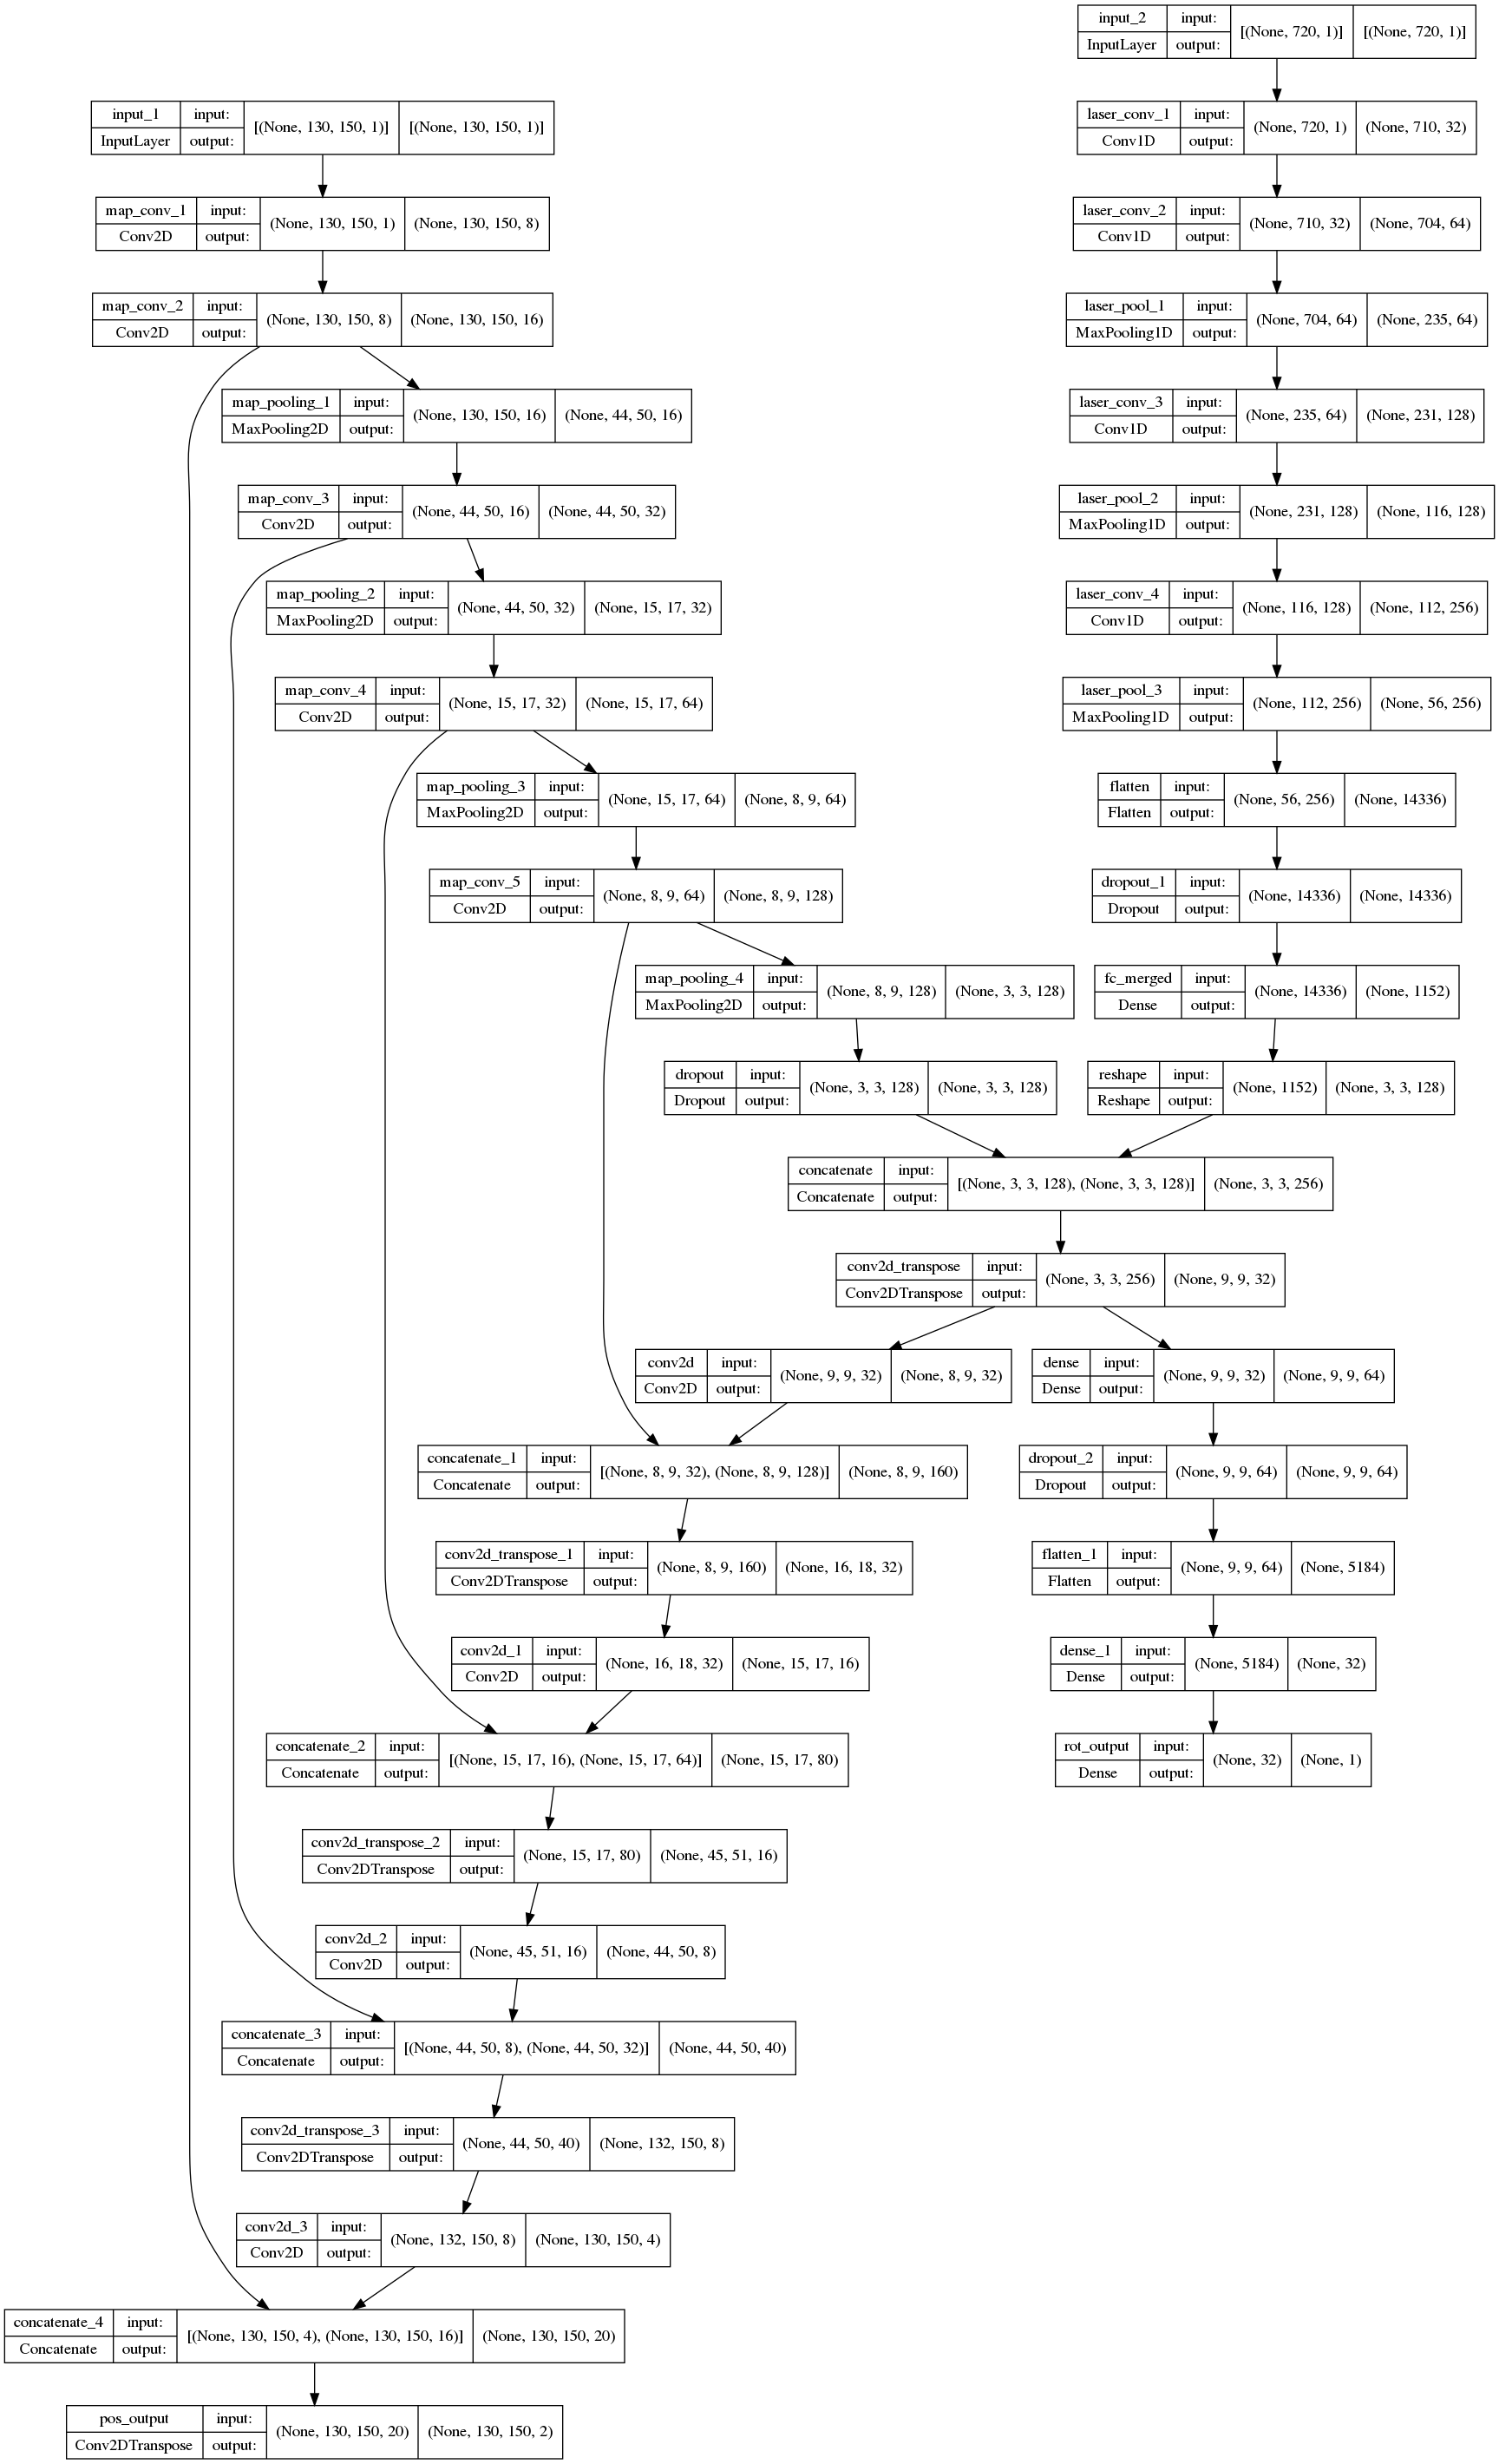

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 720, 1)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 130, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 laser_conv_1 (Conv1D)          (None, 710, 32)      384         ['input_2[0][0]']                
                                                                                                  
 map_conv_1 (Conv2D)            (None, 130, 150, 8)  976         ['input_1[0][0]']            

In [6]:
model.compile(optimizer = "adam",
    loss=[losses.SparseCategoricalCrossentropy(from_logits=True),losses.SparseCategoricalCrossentropy(from_logits=True)],#losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[None,None]    #["accuracy"]
    )

Data import

In [7]:
data = DAO("datasetmymap_multirot.csv")
data.read()
data.divide_data()

In [8]:
data.TR_features=tf.reshape(data.TR_features,[-1,720,1])
data.TS_features=tf.reshape(data.TS_features,[-1,720,1])
data.TR_targets=tf.reshape(data.TR_targets,[-1,3])
data.TS_targets=tf.reshape(data.TS_targets,[-1,3])

data.TR_targets_pos=tf.gather(data.TR_targets,[0,1],axis=1)
data.TS_targets_pos=tf.gather(data.TS_targets,[0,1],axis=1)
data.TR_targets_rot=tf.gather(data.TR_targets,[2],axis=1)
data.TS_targets_rot=tf.gather(data.TS_targets,[2],axis=1)

In [9]:
TR_map=[]
TS_map=[]

for i in range(data.TR_features.shape[0]):
    TR_map.append(map_img)

for i in range(data.TS_features.shape[0]):
    TS_map.append(map_img)

TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])
TS_map = tf.reshape(TS_map,[-1,map_img.shape[0],map_img.shape[1]])

In [10]:
from sklearn.model_selection import train_test_split

with open("data/datasetmymap_multirot_gridpos_r40.csv", "r") as file:
    laser_db_mask = pd.read_csv(file, delimiter=";",header=None).copy()

masks = laser_db_mask.drop(columns=[0])

if len(masks.values) > 2400:
    masks = masks.head(2401)

TR_x, TS_x, TR_masks, TS_masks = train_test_split(data.features, masks, test_size= 0.25, random_state= 42)

TR_masks = tf.reshape(TR_masks,[-1,map_img.shape[0],map_img.shape[1],1])
TS_masks = tf.reshape(TS_masks,[-1,map_img.shape[0],map_img.shape[1],1])

with open("data/datasetmymap_multirot_gridrot_r3_q90.csv", "r") as file:
    laser_db_mask_rot = pd.read_csv(file, delimiter=";",header=None).copy()

masks_rot = laser_db_mask_rot.drop(columns=[0])

if len(masks_rot.values) > 2400:
    masks_rot = masks_rot.head(2401)

TR_x, TS_x, TR_masks_rot, TS_masks_rot = train_test_split(data.features, masks_rot, test_size= 0.25, random_state= 42)

TR_masks_rot = tf.reshape(TR_masks_rot,[-1,90,1])
TS_masks_rot = tf.reshape(TS_masks_rot,[-1,90,1])

2022-05-12 12:27:42.666134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 274872000 exceeds 10% of free system memory.


In [11]:
def display(display_list, rot_list):

    subtitle=["True Mask", "Predicted Mask"]

    gs = gridspec.GridSpec(20, 2) 

    fig = plt.figure(figsize=(13,7))

    mask_1 = plt.subplot(gs[:19,0])
    mask_2 = plt.subplot(gs[:19,1])
    rot_1 = plt.subplot(gs[19,0])
    rot_2 = plt.subplot(gs[19,1])

    mask_1.set_title(subtitle[0])
    mask_1.imshow(tf.keras.utils.array_to_img(display_list[0]))
    mask_1.axis("off")
    
    mask_2.set_title(subtitle[1])
    mask_2.imshow(tf.keras.utils.array_to_img(display_list[1]))
    mask_2.axis("off")

    array_rot_1 = rot_list[0]
    array_rot_2 = rot_list[1]

    array_rot_1 = tf.reshape(array_rot_1,[array_rot_1.shape[1],array_rot_1.shape[0],1])
    array_rot_2 = tf.reshape(array_rot_2,[array_rot_2.shape[1],array_rot_2.shape[0],1])

    rot_1.imshow(tf.keras.utils.array_to_img(array_rot_1))
    rot_1.axis("off")

    rot_2.imshow(tf.keras.utils.array_to_img(array_rot_2))
    rot_2.axis("off")

    plt.subplots_adjust(hspace=0)
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]


Model Training

In [18]:
test_map = TS_map[0]
test_x = TS_x.values[0]

test_map = tf.reshape(test_map,[1,map_img.shape[0],map_img.shape[1],1])
test_x = tf.reshape(test_x,[1,720])

pred_test_pos,pred_test_rot = model.predict([test_map,test_x])
sample = create_mask(pred_test_pos)

#pred_test = model.predict([test_map,test_x])
#sample = create_mask(pred_test)

sample_targets = data.TS_targets_pos[0]

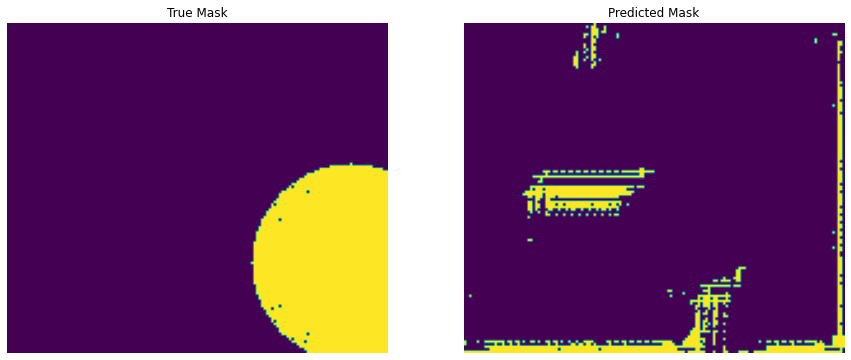

In [14]:
display([TS_masks[0],sample])

In [12]:
from IPython.display import clear_output

class MyCallback(tf.keras.callbacks.Callback):
    min_loss=10

    test_map = TS_map[0]
    test_x = TS_x.values[0]

    test_map = tf.reshape(test_map,[1,map_img.shape[0],map_img.shape[1],1])
    test_x = tf.reshape(test_x,[1,720])

    def on_epoch_end(self, epoch, logs=False):
        
        if logs["val_loss"]<self.min_loss:
            model.save_weights("models/cp-epoch-train.ckpt")
            self.min_loss = logs["val_loss"]
        
        #if epoch % 5 == 4:
            clear_output(wait=True)
            pred_output = model.predict([self.test_map,self.test_x])
            display([TS_masks[0],create_mask(pred_output[0])],[TS_masks_rot[0],create_mask(pred_output[1])])#)])

my_callback= MyCallback()

In [ ]:
history = model.fit([TR_map,data.TR_features],
    data.TR_targets_pos,#[data.TR_targets_pos, data.TR_targets_rot], 
    validation_data=([TS_map,data.TS_features],data.TS_targets_pos),#[data.TS_targets_pos,data.TS_targets_rot]), 
    verbose=1,
    batch_size=16,
    epochs=300,
    callbacks=[my_callback]
    )

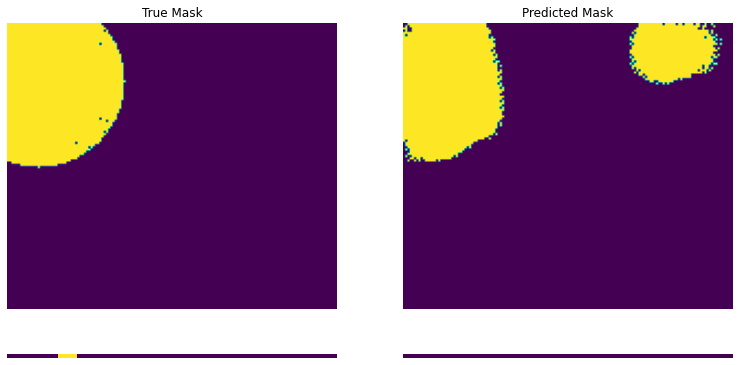

111/111 [==============================] - 16s 141ms/step - loss: 0.3264 - pos_output_loss: 0.1820 - rot_output_loss: 0.1444 - pos_output_accuracy: 0.9237 - rot_output_accuracy: 0.9452 - val_loss: 0.5022 - val_pos_output_loss: 0.3054 - val_rot_output_loss: 0.1968 - val_pos_output_accuracy: 0.8828 - val_rot_output_accuracy: 0.9441
Epoch 14/100
111/111 [==============================] - 13s 119ms/step - loss: 0.2569 - pos_output_loss: 0.1313 - rot_output_loss: 0.1256 - pos_output_accuracy: 0.9454 - rot_output_accuracy: 0.9476 - val_loss: 0.5069 - val_pos_output_loss: 0.3090 - val_rot_output_loss: 0.1979 - val_pos_output_accuracy: 0.8900 - val_rot_output_accuracy: 0.9432
Epoch 15/100
111/111 [==============================] - 13s 121ms/step - loss: 0.2187 - pos_output_loss: 0.1056 - rot_output_loss: 0.1131 - pos_output_accuracy: 0.9562 - rot_output_accuracy: 0.9507 - val_loss: 0.5828 - val_pos_output_loss: 0.3823 - val_rot_output_loss: 0.2005 - val_pos_output_accuracy: 0.8920 - val_rot_ou

KeyboardInterrupt: 

In [13]:
history = model.fit([TR_map,TR_x],
    [TR_masks, TR_masks_rot], #TR_masks,
    validation_data=([TS_map,TS_x],[TS_masks,TS_masks_rot]), #TS_masks),
    verbose=1,
    batch_size=16,
    epochs=100,
    callbacks=[my_callback]
    )

In [ ]:
my_callback.min_loss

0.9462989568710327

In [16]:
my_callback.min_loss

0.9050723314285278

Evaluation best model

In [ ]:
model = model_define(map_img, laser_inst, False)

model.load_weights("models/cp-epoch-train.ckpt")

Multi direction

In [8]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result[0]
    rot_test = result[1][:,0]
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T
    rot_real = data_eval.TS_targets_rot.numpy()[:,0]

    return pos_test, rot_test, pos_real, rot_real

In [9]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [8]:
#data_eval, map_eval = get_data("laser_log2203.csv",map_img)

#pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

#with open('predict_data2203.csv', 'w') as f:
#    for i in range(len(pos_real)):
#        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


data_eval, map_eval = get_data("laser_log2303.csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-26 15:31:45.620114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-26 15:31:46.451828: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 822.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [10]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64).csv",map_img)

pos_test, rot_test, pos_real, rot_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap(3-123,60-64).csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],rot_real[i],pos_test[i][0],pos_test[i][1],rot_test[i]))


2022-04-27 16:30:45.977861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Uni direction

In [6]:
def evaluate(model, data_tensor, TR_map):
    result = model.predict([TR_map, data_tensor.features])
    
    pos_test = result
    pos_real = np.array([data_eval.TS_targets_pos.numpy()[:,0],data_eval.TS_targets_pos.numpy()[:,1]]).T

    return pos_test, pos_real

In [7]:
def get_data(filename,map_img):
    data_test = DAO(filename)

    data_test.read()

    data_tensor_test=DAO()

    data_tensor_test.features=tf.reshape(data_test.features,[-1,720,1])
    data_tensor_test.targets=tf.reshape(data_test.targets,[-1,3])

    data_tensor_test.TS_targets_pos=tf.gather(data_test.targets,[0,1],axis=1)
    data_tensor_test.TS_targets_rot=tf.gather(data_test.targets,[2],axis=1)

    TR_map=[]

    for i in range(data_tensor_test.features.shape[0]):
        TR_map.append(map_img)

    TR_map = tf.reshape(TR_map,[-1,map_img.shape[0],map_img.shape[1]])

    return data_tensor_test, TR_map


In [16]:
data_eval, map_eval = get_data("laser_log2303_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_data2303_unidir.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))

KeyboardInterrupt: 

In [8]:
data_eval, map_eval = get_data("datasetmymap(3-123,60-64)_unidir.csv",map_img)

pos_test, pos_real = evaluate(model, data_eval, map_eval)

with open('predict_datasetmymap.csv', 'w') as f:
    for i in range(len(pos_real)):
        f.write("{};{};{};{}\n".format(pos_real[i][0],pos_real[i][1],pos_test[i][0],pos_test[i][1]))


2022-05-02 16:23:57.652676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
